# Import the libraries

In [10]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
from datetime import datetime, date
import warnings
warnings.filterwarnings("ignore")

# Load the dataset

In [38]:
# load dataset
df = pd.read_csv('air_quality_preprocessed.csv')
df.head()


,Unnamed: 0,Date_Time,CO(GT)
0,0,2004-03-10 18:00:00,2.6
1,1,2004-03-10 19:00:00,2.0
2,2,2004-03-10 20:00:00,2.2
3,3,2004-03-10 21:00:00,2.2
4,4,2004-03-10 22:00:00,1.6


In [39]:
del df['Unnamed: 0']

In [40]:
df.shape

(9357, 2)

# Visualize the data

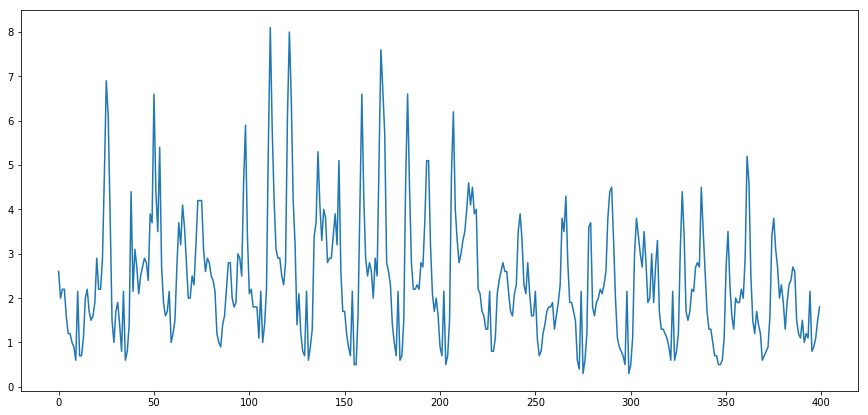

In [41]:
from matplotlib import pyplot as plt
plt.figure(figsize=(15,7))
plt.plot(df.iloc[0:400]['CO(GT)'])
plt.show()

# Stationarity Test (Dickey Fuller)

In [42]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
#     rolmean = pd.rolling_mean(timeseries, window=12)
    rolmean = timeseries.rolling(12).mean()
#     rolstd = pd.rolling_std(timeseries, window=12)
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    data1 = timeseries.iloc[:,0].values
    dftest = adfuller(data1, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [43]:
df_values = df.set_index('Date_Time')
df_values.head()

,CO(GT)
Date_Time,
2004-03-10 18:00:00,2.6
2004-03-10 19:00:00,2.0
2004-03-10 20:00:00,2.2
2004-03-10 21:00:00,2.2
2004-03-10 22:00:00,1.6


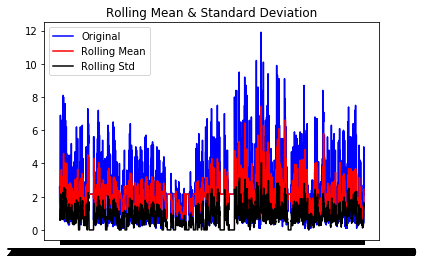

Results of Dickey-Fuller Test:
Test Statistic                -1.105066e+01
p-value                        5.089830e-20
#Lags Used                     3.600000e+01
Number of Observations Used    9.320000e+03
Critical Value (1%)           -3.431052e+00
Critical Value (5%)           -2.861850e+00
Critical Value (10%)          -2.566935e+00
dtype: float64


In [20]:

test_stationarity(df_values)

# Transform Time Series to Supervised Learning

In [44]:

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(df_local, lag=1):
#     df = pd.DataFrame(data)
    columns = [df_local.shift(i) for i in range(1, lag+1)]
    columns.append(df_local)
    df_local = pd.concat(columns, axis=1)
    df_local.fillna(0, inplace=True)
    return df_local

In [45]:
df_supervised = timeseries_to_supervised(df_values, 1)

In [47]:
df_supervised.columns = ['Previous CO(GT)', 'Current CO(GT)']

In [48]:
df_supervised.head()

,Previous CO(GT),Current CO(GT)
Date_Time,,
2004-03-10 18:00:00,0.0,2.6
2004-03-10 19:00:00,2.6,2.0
2004-03-10 20:00:00,2.0,2.2
2004-03-10 21:00:00,2.2,2.2
2004-03-10 22:00:00,2.2,1.6


# Split dataset into train and test

In [105]:
train, test = df_supervised[:7680], df_supervised[7680:]

In [106]:
train.shape

(7680, 2)

In [107]:
test.shape

(1677, 2)

# Scale the data

In [142]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
#     scaler = StandardScaler()
    scaler = scaler.fit(train)
    # transform train
#     train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
#     test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [201]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [144]:
scaler, train_scaled, test_scaled = scale(train.values, test)

In [145]:
train_scaled

array([[-1.        , -0.57627119],
       [-0.56302521, -0.6779661 ],
       [-0.66386555, -0.6440678 ],
       ...,
       [-0.88235294, -0.83050847],
       [-0.81512605, -0.79661017],
       [-0.78151261, -0.84745763]])

# Fit the LSTM Model

In [162]:

from numpy.random import seed
seed(42)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


In [163]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

In [164]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 10, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

Epoch 1/1
7680/7680 [==============================] - 11s 1ms/step - loss: 0.0330
Epoch 1/1
7680/7680 [==============================] - 11s 1ms/step - loss: 0.0174
Epoch 1/1
7680/7680 [==============================] - 10s 1ms/step - loss: 0.0164
Epoch 1/1
7680/7680 [==============================] - 10s 1ms/step - loss: 0.0162
Epoch 1/1
7680/7680 [==============================] - 10s 1ms/step - loss: 0.0162
Epoch 1/1
7680/7680 [==============================] - 10s 1ms/step - loss: 0.0162
Epoch 1/1
7680/7680 [==============================] - 10s 1ms/step - loss: 0.0162
Epoch 1/1
7680/7680 [==============================] - 11s 1ms/step - loss: 0.0161
Epoch 1/1
7680/7680 [==============================] - 10s 1ms/step - loss: 0.0161
Epoch 1/1
7680/7680 [==============================] - 10s 1ms/step - loss: 0.0161


array([[-0.72098565],
       [-0.6148985 ],
       [-0.7546988 ],
       ...,
       [-0.864834  ],
       [-0.7941381 ],
       [-0.7843141 ]], dtype=float32)

# Forecast

In [165]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
#     yhat = model.predict(X)
    return yhat[0,0]

In [202]:
# walk-forward validation on the test data
predictions = list()
expected_list = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
#     yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = df.values[len(train) + i]
    expected_list.append(expected)
#     print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
#     print(type(yhat))
results = pd.DataFrame(predictions)
# print(expected.shape)
results['Actuals'] = expected_list
# results

Test RMSE: 0.738


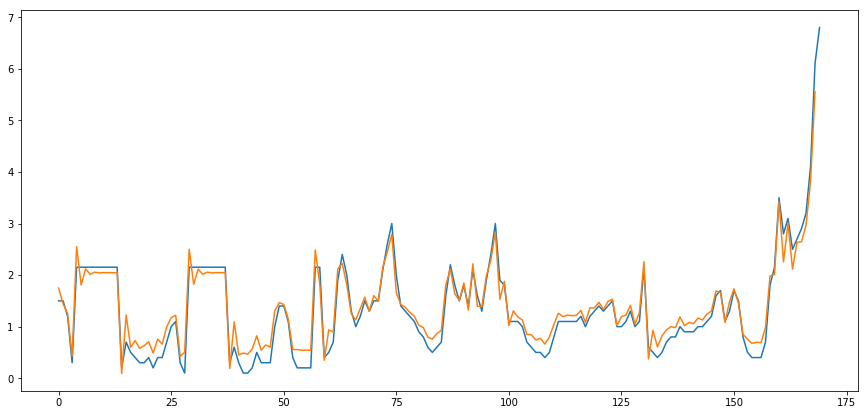

In [203]:
# report performance
from math import sqrt
from sklearn.metrics import mean_squared_error

rmse = sqrt(mean_squared_error(df[['CO(GT)']].values[7680:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.figure(figsize=(15,7))
pyplot.plot(df[['CO(GT)']].values[7680:7850])
pyplot.plot(predictions[1:170])
pyplot.show()